# Project 2 

### 1. Background

The purpose of this project is to understand the correlation and links between different variables and attitudes towards mental health. The nature of the data set that I am interepreting is that it comes from an open source data set that was obtained through a survey taken by individuals working at tech organizations around the world. This survey was conducted by OSMI, Open Sourcing Mental Illness, an organization dedicated to understanding and educating individuals about these attitudes and the effects they have. 


In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats
import numpy as np
from datetime import datetime
from dateutil.parser import parse
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import l1_min_c
from sklearn.metrics import roc_curve, auc
sns.set_context('talk')
sns.set_style('darkgrid')
sns.set_palette('colorblind')

In [32]:
data = pd.read_csv('https://docs.google.com/spreadsheets/d/1cr65P3ciL2tD4W4KOCTz4Ik67iD52S_DKHXypqgta2o/export?format=csv')

reassign the names of the columns to change lengthy survey question titles to short variable names to simplify later analysis

In [33]:
data.columns = ['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'comments' ]
data.head(1)

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,8/27/2014 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN


In [34]:
data = data.reset_index(drop=True); 

#### Adding country - continent dataset

In [35]:
data_country = pd.read_csv('https://raw.githubusercontent.com/dbouquin/IS_608/master/NanosatDB_munging/Countries-Continents.csv')
data_country.head()

,Continent,Country
0,Africa,Algeria
1,Africa,Angola
2,Africa,Benin
3,Africa,Botswana
4,Africa,Burkina


In [36]:
data_country = data_country.replace('US', 'United States')

In [37]:
data_country = data_country.set_index('Continent')
data_country.head()

,Country
Continent,
Africa,Algeria
Africa,Angola
Africa,Benin
Africa,Botswana
Africa,Burkina


In [38]:
data_dict = data_country.to_dict()
print(data_dict)

{'Country': {'Africa': 'Zimbabwe', 'Asia': 'Yemen', 'Europe': 'Vatican City', 'North America': 'United States', 'Oceania': 'Vanuatu', 'South America': 'Venezuela'}}


In [39]:
#data_dict = data_country.to_dict()
#data['Continent'] = data['Country'].map(data_dict)
#data['Continent'].head()

*Need to find a way to add country data & merge a valuable data set -- not really sure what data set to merge.*

### summarizing the data to understand what needs to be cleaned 

In [40]:
data.describe(include=['O'])

,Timestamp,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
count,1260,1260,1260,744,1242,1260,1260,996,1260,1260,...,1260,1260,1260,1260,1260,1260,1260,1260,1260,164
unique,1249,49,48,45,2,2,2,4,6,2,...,5,3,3,3,3,3,3,3,2,160
top,8/27/2014 16:39:01,Male,United States,CA,No,No,Yes,Sometimes,6-25,No,...,Don't know,No,No,Some of them,Yes,No,Maybe,Don't know,No,* Small family business - YMMV.
freq,2,616,751,138,1096,768,637,466,290,884,...,564,490,926,775,516,1009,558,576,1075,5


In [41]:
#date_string = data.Timestamp;
#date_object = datetime.strptime(date_string, '%d/%m/%Y %I:%M:%p')
#print(date_object)

#df['col'] = pd.to_datetime(df['Timestamp'])

In [42]:
rows = len(data.index)
print ('Number of rows of rows in the table: ', rows)

Number of rows of rows in the table:  1260


### Variables: 

+ **Timestamp**
+ **Age**
+ **Gender**
+ **Country**
+ **state**: If you live in the United States, which state or territory do you live in?
+ **self_employed**: Are you self-employed?
+ **family_history**: Do you have a family history of mental illness?
+ **treatment**: Have you sought treatment for a mental health condition?
+ **work_interfere**: If you have a mental health condition, do you feel that it interferes with your work?
+ **no_employees**: How many employees does your company or organization have?
+ **remote_work**: Do you work remotely (outside of an office) at least 50% of the time?
+ **tech_company**: Is your employer primarily a tech company/organization?
+ **benefits**: Does your employer provide mental health benefits?
+ **care_options**: Do you know the options for mental health care your employer provides?
+ **wellness_program**: Has your employer ever discussed mental health as part of an employee wellness program?
+ **seek_help**: Does your employer provide resources to learn more about mental health issues and how to seek help?
+ **anonymity**: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?
+ **leave**: How easy is it for you to take medical leave for a mental health condition?
+ **mental_health_consequence**: Do you think that discussing a mental health issue with your employer would have negative consequences?
+ **phys_health_consequence**: Do you think that discussing a physical health issue with your employer would have negative consequences?
+ **coworkers:** Would you be willing to discuss a mental health issue with your coworkers?
+ **supervisor:** Would you be willing to discuss a mental health issue with your direct supervisor(s)?
+ **mental_health_interview:** Would you bring up a mental health issue with a potential employer in an interview?
+ **phys_health_interview:** Would you bring up a physical health issue with a potential employer in an interview?
+ **mental_vs_physical:** Do you feel that your employer takes mental health as seriously as physical health?
+ **obs_consequence:** Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?
+ **comments:** Any additional notes or comments

## 2. Cleaning the Data

First, we will see what types of variables are available with the data set. 

k

In [43]:
data.dtypes

Timestamp                    object
Age                           int64
Gender                       object
Country                      object
state                        object
self_employed                object
family_history               object
treatment                    object
work_interfere               object
no_employees                 object
remote_work                  object
tech_company                 object
benefits                     object
care_options                 object
wellness_program             object
seek_help                    object
anonymity                    object
leave                        object
mental_health_consequence    object
phys_health_consequence      object
coworkers                    object
supervisor                   object
mental_health_interview      object
phys_health_interview        object
mental_vs_physical           object
obs_consequence              object
comments                     object
dtype: object

Now, to see what if any variables are missing.

Variables to convert to be used in modeling: Gender, Country, State, ...

Timestamp                       0
Age                             0
Gender                          0
Country                         0
state                         516
self_employed                  18
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1096
dtype: int64


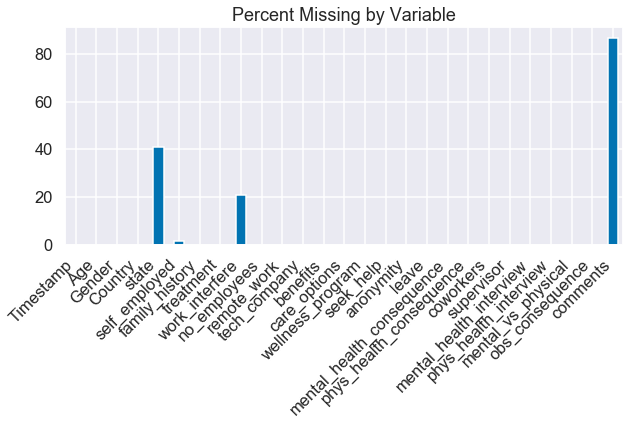

In [44]:
f, ax = plt.subplots(figsize=(10,4))
((data.isnull().sum()/len(data)) * 100).plot(kind='bar')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Percent Missing by Variable')
print((data.isnull().sum()));

It can be noted that the variables with missing variables are: state, self employed, work interfere, and comments. There is missing state data because not all of the individuals who took the survey live in the U.S. 

Moreover, the reason why there since there is so much data missing in comments, and that information is not necessary for my data analysis, we can get rid of that variable. 

We will also look at the self employed and work interference columns to see what is happening there. 

First we will get rid of the comments column:

text = data['Cell Line'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [45]:
data.drop('comments', axis=1, inplace = True)

In [46]:
data.head(1)

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,8/27/2014 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No


### 2a.  Cleaning the gender data

In [47]:
data['Gender'] = data['Gender'].str.lower()

In [48]:
data.Gender.value_counts()#.plot(kind='bar')
#plt.xticks(rotation=0, horizontalalignment='center')
data.Gender.nunique()

43

Needs to be cleaned -- there are various different versions of each gender and other versions that make the data set complicated. 
Male,male,M,m,Make,Man,Mail,msle,maile,Male-ish,Mal,Cis Male, Female (trans), Malr, cis male, Male (CIS), Cis Man
Female,female,F,f,Woman, Female (cis), cis-female/femme
Nah, A little about you, Genderqueer, non-binary, p, queer

In [49]:
gender_df = data["Gender"]
type(gender_df)
terms_to_remove = ["trans", "cis", "queer", "-", "^", "_", ",", "(", ")", "/", "?"]
for i, gender_str in enumerate(gender_df):
    # convert to lowercase
    gender_lowercase_str = gender_str.lower()
    for term in terms_to_remove:
      gender_lowercase_str = gender_lowercase_str.replace(term, "")
    if gender_lowercase_str.startswith("f") or gender_lowercase_str.startswith("she") or "woman" in gender_lowercase_str:
      gender_lowercase_str = "female"
    elif gender_lowercase_str.startswith("m") or "male" in gender_lowercase_str:
      gender_lowercase_str = "male"
    else:
      gender_lowercase_str = "non-binary"

    gender_df[i] = gender_lowercase_str

/miniconda3/envs/em212/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [50]:
data.Gender.value_counts()

male          995
female        252
non-binary     13
Name: Gender, dtype: int64

Since there are not enough non-binary individuals to analyze any significant correlations and since it is not the focus of this project, we will drop this variable. 

In [51]:
data = data[data.Gender != 'non-binary'];

#### Make the gender variable boolean

In [52]:
data = pd.concat([data, pd.get_dummies(data.Gender, drop_first=False)], axis=1)

In [53]:
data.head(3)

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,female,male
0,8/27/2014 11:29:31,37,female,United States,IL,NaN,No,Yes,Often,6-25,...,No,No,Some of them,Yes,No,Maybe,Yes,No,1,0
1,8/27/2014 11:29:37,44,male,United States,IN,NaN,No,No,Rarely,More than 1000,...,Maybe,No,No,No,No,No,Don't know,No,0,1
2,8/27/2014 11:29:44,32,male,Canada,NaN,NaN,No,No,Rarely,6-25,...,No,No,Yes,Yes,Yes,Yes,No,No,0,1


In [54]:
data.Gender.value_counts()

male      995
female    252
Name: Gender, dtype: int64

### 2b. Cleaning the country data

In terms of how many different countries are represented in the survey, the counts can be seen below: 

In [55]:
data.Country.value_counts()

United States             747
United Kingdom            180
Canada                     71
Germany                    44
Netherlands                27
Ireland                    27
Australia                  22
France                     13
India                      10
New Zealand                 8
Switzerland                 7
Sweden                      7
Poland                      7
Italy                       7
Brazil                      6
South Africa                6
Belgium                     6
Israel                      5
Bulgaria                    4
Singapore                   4
Austria                     3
Russia                      3
Finland                     3
Mexico                      3
Colombia                    2
Portugal                    2
Greece                      2
Croatia                     2
Denmark                     2
Romania                     1
China                       1
Latvia                      1
Moldova                     1
Hungary   

The continents that are represented are -  
**North America ; Europe ; Australia ; Asia ; South America**  
However, the majority of the resposes are concentrated in North America and Europe, and the other countries would not provide a thorough and well-informed interpretation. Thus, we can eliminate the data from the survey responses from the other countires.

### 2c. Cleaning the Age Data

In [56]:
data.describe()

,Age,female,male
count,1247.000000,1247.000000,1247.000000
mean,30.846832,0.202085,0.797915
std,51.057106,0.401716,0.401716
min,-1726.000000,0.000000,0.000000
25%,27.000000,0.000000,1.000000
50%,31.000000,0.000000,1.000000
75%,36.000000,0.000000,1.000000
max,329.000000,1.000000,1.000000


Seeing that the distribtion is skewed do to the minimum and maximum ages, we can normalize these by eliminating ages that are not realistic for the working population. Since it can be assumed that individuals over 110 likely do not work as well as those under the age of 12, we can eliminate data that skews the averages. So we insert the average of the data (with the outliers taken out) to be the ages of those outliers: 

In [57]:
data.loc[(data['Age'] > 110), 'Age'] = 32
data.loc[(data['Age'] < 12), 'Age'] = 32

In [58]:
data.describe()

,Age,female,male
count,1247.000000,1247.000000,1247.000000
mean,32.105854,0.202085,0.797915
std,7.282867,0.401716,0.401716
min,18.000000,0.000000,0.000000
25%,27.000000,0.000000,1.000000
50%,31.000000,0.000000,1.000000
75%,36.000000,0.000000,1.000000
max,72.000000,1.000000,1.000000


## 2. Data Interpretation

Do you have a family history of mental illness?

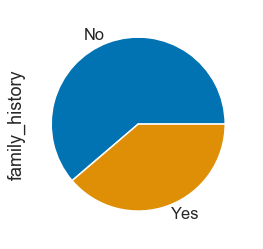

In [59]:
dfh= data.family_history.value_counts();
dfh.plot(kind='pie')

Have you sought treatment for a mental health condition?

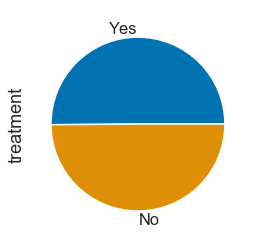

In [60]:
dt= data.treatment.value_counts();
dt.plot(kind='pie')

Text(0.5, -0.05, 'Age')

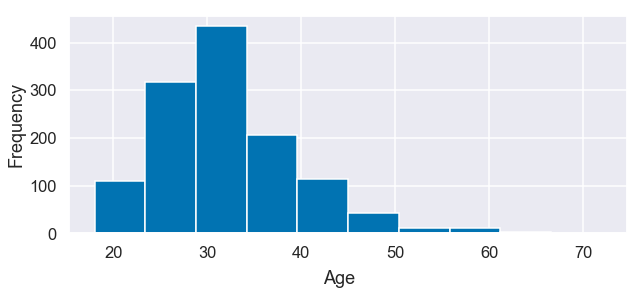

In [61]:
f, ax = plt.subplots(figsize=(10,4))
data.Age.plot(kind='hist')
plt.xticks(rotation=0, horizontalalignment='center')
f.text(0.5, -0.05, 'Age', ha='center')

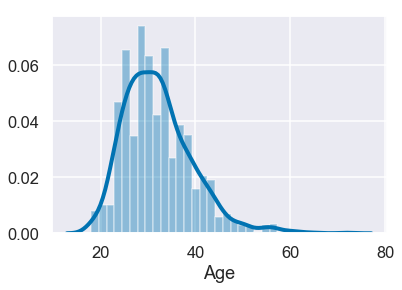

In [62]:
sns.distplot(data['Age'],hist=True, kde=True, 
             #bins=int(180/5), color = 'darkblue', 
             #hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [63]:
#dc= data.Country.value_counts()
#dc.plot(kind='pie')
data.Country.nunique()

46

Need to continue analysis and interpretation...

In [64]:
#data.Country.value_counts()

In [65]:
data['Continent'] = data['Country'].map(data_dict)
data.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,female,male,Continent
0,8/27/2014 11:29:31,37,female,United States,IL,NaN,No,Yes,Often,6-25,...,No,Some of them,Yes,No,Maybe,Yes,No,1,0,NaN
1,8/27/2014 11:29:37,44,male,United States,IN,NaN,No,No,Rarely,More than 1000,...,No,No,No,No,No,Don't know,No,0,1,NaN
2,8/27/2014 11:29:44,32,male,Canada,NaN,NaN,No,No,Rarely,6-25,...,No,Yes,Yes,Yes,Yes,No,No,0,1,NaN
3,8/27/2014 11:29:46,31,male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Yes,Some of them,No,Maybe,Maybe,No,Yes,0,1,NaN
4,8/27/2014 11:30:22,31,male,United States,TX,NaN,No,No,Never,100-500,...,No,Some of them,Yes,Yes,Yes,Don't know,No,0,1,NaN


In [66]:
cor = data.corr()
cor
data.dtypes

Timestamp                    object
Age                           int64
Gender                       object
Country                      object
state                        object
self_employed                object
family_history               object
treatment                    object
work_interfere               object
no_employees                 object
remote_work                  object
tech_company                 object
benefits                     object
care_options                 object
wellness_program             object
seek_help                    object
anonymity                    object
leave                        object
mental_health_consequence    object
phys_health_consequence      object
coworkers                    object
supervisor                   object
mental_health_interview      object
phys_health_interview        object
mental_vs_physical           object
obs_consequence              object
female                        uint8
male                        

In [68]:
df1=pd.DataFrame(data)
#demograhics 
df1['male'] = data['male'].astype('category').cat.codes
df1['female'] = data['female'].astype('category').cat.codes
df1['Country'] = data['Country'].astype('category').cat.codes
df1['state'] = data['state'].astype('category').cat.codes
#personal
df1['family_history'] = data['family_history'].astype('category').cat.codes
df1['treatment'] = data['treatment'].astype('category').cat.codes
#about the company
df1['care_options'] = data['care_options'].astype('category').cat.codes
df1['wellness_program'] = data['wellness_program'].astype('category').cat.codes
df1['seek_help'] = data['seek_help'].astype('category').cat.codes
df1['mental_health_consequence'] = data['mental_health_consequence'].astype('category').cat.codes
df1['phys_health_consequence'] = data['phys_health_consequence'].astype('category').cat.codes
df1['coworkers'] = data['coworkers'].astype('category').cat.codes
df1['supervisor'] = data['supervisor'].astype('category').cat.codes
df1['mental_vs_physical'] = data['mental_vs_physical'].astype('category').cat.codes
df1['obs_consequence'] = data['obs_consequence'].astype('category').cat.codes

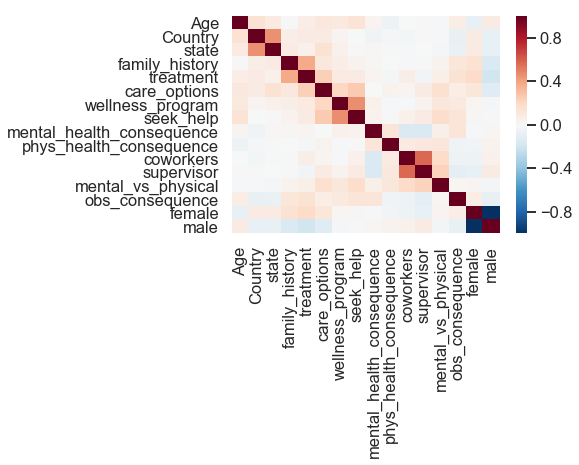

In [70]:
corr=df1.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap = 'RdBu_r')
#corr.style.background_gradient(cmap='RdBu_r', axis=1).set_precision(2)

In [ ]:
#df2 = df1.astype('category')

In [ ]:
#df2.dtypes

In [ ]:
#sns.heatmap(df2)

In [ ]:
print((data.isnull().sum()));